In [1]:
import pandas as pd
import os

# 1. 작업 경로 설정
base_path = r'C:\Workspace\Sobol\9_Gumbel risk analysis'
obs_filename = 'Data 01 Annual Max Water Year - Observation.csv'
sim_filename = 'Data 02 Anual Max Water Year - Sobol Simulation.csv'

# 2. 파일 전체 경로 생성
obs_path = os.path.join(base_path, obs_filename)
sim_path = os.path.join(base_path, sim_filename)

try:
    # 3. 데이터 로드
    obs_df = pd.read_csv(obs_path)
    sim_df = pd.read_csv(sim_path)

    # 4. 데이터 구조 확인 (첫 5행 및 정보 출력)
    print("--- [Observation Data Sample] ---")
    print(obs_df.head())
    print("\n--- [Observation Data Info] ---")
    print(obs_df.info())

    print("\n" + "="*50 + "\n")

    print("--- [Simulation Data Sample] ---")
    print(sim_df.head())
    print("\n--- [Simulation Data Info] ---")
    print(sim_df.info())

except FileNotFoundError as e:
    print(f"파일을 찾을 수 없습니다. 경로를 다시 확인해주세요: {e}")
except Exception as e:
    print(f"오류가 발생했습니다: {e}")

--- [Observation Data Sample] ---
   water_year  annual_max_cms
0        1989      233.104281
1        1990      377.180397
2        1991      559.597522
3        1992      133.655516
4        1993      455.901230

--- [Observation Data Info] ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   water_year      37 non-null     int64  
 1   annual_max_cms  37 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 724.0 bytes
None


--- [Simulation Data Sample] ---
   WaterYear    sim1   sim2   sim3   sim4    sim5   sim6    sim7   sim8  \
0       2012  260.50  430.0  562.6  560.8  309.50  153.0   802.7  377.0   
1       2013   73.34  152.8  193.9  237.0   99.88   81.5   377.0  172.5   
2       2014  116.90  527.3  581.4  697.8  275.90   87.6  1069.0  347.4   
3       2015  268.70  417.0  437.1  559.3  290.20  147.7   839.7  312.1   
4

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import t

# 1. 데이터 정렬 (Rank in ascending order)
obs_sorted = np.sort(obs_df['annual_max_cms'].values)
n = len(obs_sorted)
i = np.arange(1, n + 1)  # 순위 (1부터 n까지)

# 2. 비초과 확률 계산 (Gringorten's formula, alpha = 0.44)
alpha = 0.44
Fi = (i - alpha) / (n + 1 - 2 * alpha)

# 3. 표준화 변량 계산 (Standardized variate, yi)
# 식: yi = -ln(-ln(Fi))
yi = -np.log(-np.log(Fi))

# 결과 확인을 위한 데이터프레임 구성
step1_3_df = pd.DataFrame({
    'Rank(i)': i,
    'Observed_X': obs_sorted,
    'Prob_Fi': Fi,
    'Variate_yi': yi
})

print("--- [1단계 ~ 3단계 결과 (상위 5개)] ---")
print(step1_3_df.head())

--- [1단계 ~ 3단계 결과 (상위 5개)] ---
   Rank(i)  Observed_X   Prob_Fi  Variate_yi
0        1  133.655516  0.015086   -1.433649
1        2  186.947821  0.042026   -1.153564
2        3  187.565128  0.068966   -0.983631
3        4  188.023861  0.095905   -0.852028
4        5  189.213169  0.122845   -0.740428


In [3]:
# 4. 분포 매개변수 계산 (Compute distribution parameters)

# 데이터의 평균(mean)과 분산(variance) 계산
obs_mean = np.mean(obs_sorted)
obs_var = np.var(obs_sorted, ddof=1) # n-1로 나누는 불편분산 사용

# Scale parameter (a) 계산: sigma^2 = (pi^2 * a^2) / 6 식을 a에 대해 정리
# a = sqrt(6 * var / pi^2)
a_param = np.sqrt(6 * obs_var / np.pi**2)

# Location parameter (c) 계산: mu = c + 0.5772 * a 식을 c에 대해 정리
# c = mu - 0.5772 * a
c_param = obs_mean - 0.5772 * a_param

print("--- [4단계: Distribution Parameters] ---")
print(f"Sample Mean (μ): {obs_mean:.4f}")
print(f"Sample Variance (σ²): {obs_var:.4f}")
print(f"Scale Parameter (a): {a_param:.4f}")
print(f"Location Parameter (c): {c_param:.4f}")

--- [4단계: Distribution Parameters] ---
Sample Mean (μ): 503.0371
Sample Variance (σ²): 70309.5049
Scale Parameter (a): 206.7439
Location Parameter (c): 383.7045


In [4]:
from scipy.stats import t

# 5. Quantile 추정 (Estimate the quantiles)
# X_est = c + a * yi (수식 3.17)
X_est = c_param + a_param * yi

# 6. 추정치의 가변성 결정 (Determine the variability of the quantile estimates)
# var_X_est = (a^2 / n) * (1.17 + 0.196*yi + 1.099*yi^2) (수식 3.18)
var_X_est = (a_param**2 / n) * (1.17 + 0.196 * yi + 1.099 * yi**2)
std_error = np.sqrt(var_X_est) # 표준 오차

# 7. 95% 신뢰 한계 계산 (Compute confidence limits)
# t-value: 97.5% (두 갈래 테스트이므로 0.05/2), 자유도 n-1
t_val = t.ppf(0.975, n - 1)

lower_CL = X_est - t_val * std_error
upper_CL = X_est + t_val * std_error

# 결과 병합
analysis_df = pd.DataFrame({
    'Rank(i)': i,
    'Observed_X': obs_sorted,
    'Variate_yi': yi,
    'Estimated_X': X_est,
    'Lower_95_CL': lower_CL,
    'Upper_95_CL': upper_CL
})

print("--- [5~7단계: Quantile & Confidence Limits] ---")
print(analysis_df.tail()) # 상위 유량(큰 값) 쪽 확인

--- [5~7단계: Quantile & Confidence Limits] ---
    Rank(i)   Observed_X  Variate_yi  Estimated_X  Lower_95_CL  Upper_95_CL
32       33   801.423392    2.032013   803.810897   633.476222   974.145572
33       34   803.348938    2.294408   858.059477   670.478924  1045.640030
34       35   875.018877    2.638632   929.225612   718.573351  1139.877874
35       36  1080.004529    3.148080  1034.550837   789.105412  1279.996263
36       37  1441.610660    4.186383  1249.213849   931.443270  1566.984429


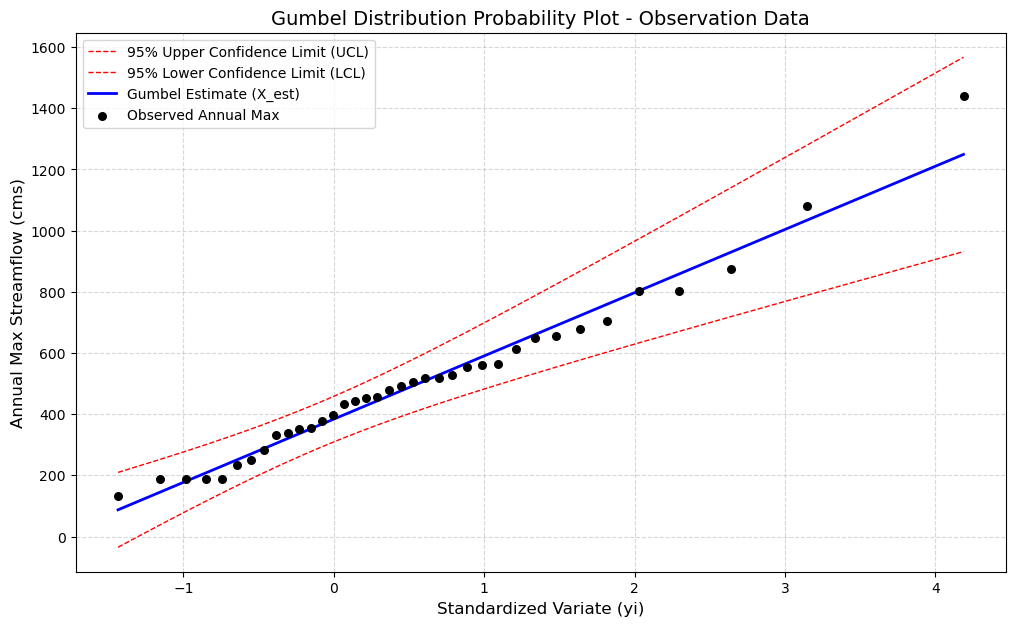

In [5]:
import matplotlib.pyplot as plt

# 그래프 크기 설정
plt.figure(figsize=(12, 7))

# 1. 신뢰 구간(UCL, LCL) 시각화 - 점선(Dashed line)
plt.plot(analysis_df['Variate_yi'], analysis_df['Upper_95_CL'], 'r--', linewidth=1, label='95% Upper Confidence Limit (UCL)')
plt.plot(analysis_df['Variate_yi'], analysis_df['Lower_95_CL'], 'r--', linewidth=1, label='95% Lower Confidence Limit (LCL)')

# 2. Gumbel 추정선(Xest) 시각화 - 실선(Solid line)
plt.plot(analysis_df['Variate_yi'], analysis_df['Estimated_X'], 'b-', linewidth=2, label='Gumbel Estimate (X_est)')

# 3. 실제 관측 데이터(Observed_X) 시각화 - 점(Scatter)
plt.scatter(analysis_df['Variate_yi'], analysis_df['Observed_X'], color='black', s=30, label='Observed Annual Max', zorder=3)

# 그래프 꾸미기
plt.title('Gumbel Distribution Probability Plot - Observation Data', fontsize=14)
plt.xlabel('Standardized Variate (yi)', fontsize=12)
plt.ylabel('Annual Max Streamflow (cms)', fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()

# 그래프 출력
plt.show()

In [7]:
import numpy as np
import pandas as pd

# 1. 분석할 시뮬레이션 컬럼 리스트 (sim1 ~ sim5)
sim_cols = ['sim1', 'sim2', 'sim3', 'sim4', 'sim5']

# 결과를 저장할 딕셔너리
sim_results = {}

print(f"--- [Simulation Columns (sim1~sim5) Verification] ---")

for col in sim_cols:
    # A. 해당 컬럼 데이터 추출 및 오름차순 정렬
    data = sim_df[col].dropna().values
    data_sorted = np.sort(data)
    
    n = len(data_sorted)
    i = np.arange(1, n + 1)
    
    # B. Gringorten 공식 적용 (alpha = 0.44)
    alpha = 0.44
    Fi = (i - alpha) / (n + 1 - 2 * alpha)
    
    # C. 표준화 변량 yi 계산
    yi = -np.log(-np.log(Fi))
    
    # D. 데이터프레임 저장 (검증용)
    res_df = pd.DataFrame({
        'Rank(i)': i,
        'Sorted_X': data_sorted,
        'Prob_Fi': Fi,
        'Variate_yi': yi
    })
    
    sim_results[col] = res_df
    
    # 각 컬럼의 첫 5개 행 출력
    print(f"\n[{col} 결과 (n={n})]")
    print(res_df.head(5).to_string(index=False))

--- [Simulation Columns (sim1~sim5) Verification] ---

[sim1 결과 (n=9)]
 Rank(i)  Sorted_X  Prob_Fi  Variate_yi
       1     73.34 0.061404   -1.026145
       2     82.19 0.171053   -0.568595
       3    116.90 0.280702   -0.239381
       4    195.60 0.390351    0.061121
       5    256.00 0.500000    0.366513

[sim2 결과 (n=9)]
 Rank(i)  Sorted_X  Prob_Fi  Variate_yi
       1     152.8 0.061404   -1.026145
       2     184.4 0.171053   -0.568595
       3     294.1 0.280702   -0.239381
       4     352.9 0.390351    0.061121
       5     361.0 0.500000    0.366513

[sim3 결과 (n=9)]
 Rank(i)  Sorted_X  Prob_Fi  Variate_yi
       1     193.9 0.061404   -1.026145
       2     195.7 0.171053   -0.568595
       3     324.3 0.280702   -0.239381
       4     427.5 0.390351    0.061121
       5     437.1 0.500000    0.366513

[sim4 결과 (n=9)]
 Rank(i)  Sorted_X  Prob_Fi  Variate_yi
       1     237.0 0.061404   -1.026145
       2     281.7 0.171053   -0.568595
       3     428.5 0.280702   -0.23938

--- [Risk Analysis: sim1 ~ sim5] ---
sim1: Out of range = 8/9 points, Risk = 88.89%
sim2: Out of range = 5/9 points, Risk = 55.56%
sim3: Out of range = 2/9 points, Risk = 22.22%
sim4: Out of range = 3/9 points, Risk = 33.33%
sim5: Out of range = 8/9 points, Risk = 88.89%


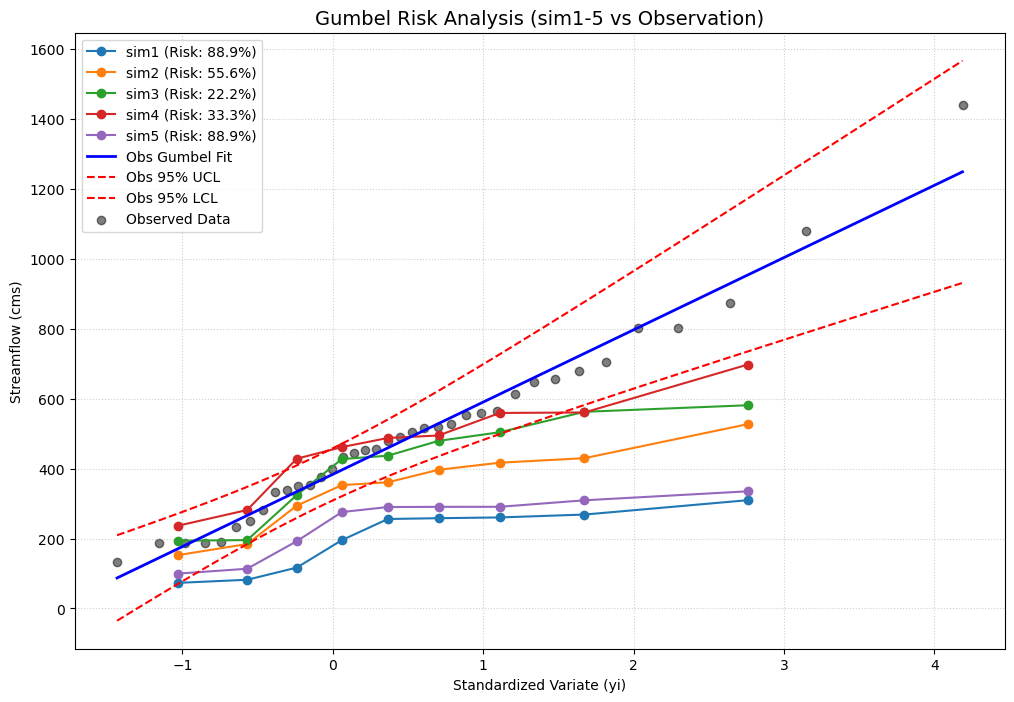

In [8]:
import matplotlib.pyplot as plt

# 1. 분석 대상 컬럼 설정
target_sims = ['sim1', 'sim2', 'sim3', 'sim4', 'sim5']
n_obs = len(obs_sorted) # 관측 데이터 개수 (37)

print("--- [Risk Analysis: sim1 ~ sim5] ---")

plt.figure(figsize=(12, 8))

# 2. 각 시뮬레이션별 분석 및 플롯
for col in target_sims:
    # 데이터 준비
    data_sorted = np.sort(sim_df[col].dropna().values)
    n_s = len(data_sorted)
    i_s = np.arange(1, n_s + 1)
    fi_s = (i_s - 0.44) / (n_s + 1 - 0.88)
    yi_s = -np.log(-np.log(fi_s))
    
    # 해당 yi_s 지점에서의 관측치 기반 UCL, LCL 계산 (수식 3.18, 3.19)
    # n 파라미터는 신뢰구간의 기준이 되는 관측 데이터 개수(37)를 사용해야 합니다.
    var_x = (a_param**2 / n_obs) * (1.17 + 0.196 * yi_s + 1.099 * yi_s**2)
    std_err = np.sqrt(var_x)
    
    ucl_s = (c_param + a_param * yi_s) + t_val * std_err
    lcl_s = (c_param + a_param * yi_s) - t_val * std_err
    
    # 리스크 계산 (범위를 벗어난 데이터 개수)
    out_mask = (data_sorted > ucl_s) | (data_sorted < lcl_s)
    out_count = np.sum(out_mask)
    risk_percent = (out_count / n_s) * 100
    
    print(f"{col}: Out of range = {out_count}/{n_s} points, Risk = {risk_percent:.2f}%")
    
    # 그래프에 시뮬레이션 선 추가
    plt.plot(yi_s, data_sorted, marker='o', label=f'{col} (Risk: {risk_percent:.1f}%)')

# 3. 관측 데이터 기준선 및 신뢰구간 추가 (비교 기준)
# 부드러운 곡선을 위해 더 촘촘한 yi 범위를 생성합니다.
yi_range = np.linspace(analysis_df['Variate_yi'].min(), analysis_df['Variate_yi'].max(), 100)
var_range = (a_param**2 / n_obs) * (1.17 + 0.196 * yi_range + 1.099 * yi_range**2)
ucl_range = (c_param + a_param * yi_range) + t_val * np.sqrt(var_range)
lcl_range = (c_param + a_param * yi_range) - t_val * np.sqrt(var_range)
x_est_range = c_param + a_param * yi_range

plt.plot(yi_range, x_est_range, 'b-', linewidth=2, label='Obs Gumbel Fit')
plt.plot(yi_range, ucl_range, 'r--', label='Obs 95% UCL')
plt.plot(yi_range, lcl_range, 'r--', label='Obs 95% LCL')
plt.scatter(analysis_df['Variate_yi'], analysis_df['Observed_X'], color='black', alpha=0.5, label='Observed Data')

# 그래프 설정
plt.title('Gumbel Risk Analysis (sim1-5 vs Observation)', fontsize=14)
plt.xlabel('Standardized Variate (yi)')
plt.ylabel('Streamflow (cms)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

In [10]:
import pandas as pd
import numpy as np
import os
from scipy.stats import t

# 1. 결과 저장을 위한 리스트 초기화
full_risk_results = []

# 관측 데이터 기준 정보
n_obs = len(obs_sorted)
sim_only_cols = [c for c in sim_df.columns if c.startswith('sim')]

# f-string 포맷 수정: {len(sim_only_cols):,} 는 천 단위 쉼표를 찍어줍니다.
print(f"전체 {len(sim_only_cols):,}개 시뮬레이션 분석을 시작합니다...")

# 2. 모든 시뮬레이션 컬럼 순회 루프
for col in sim_only_cols:
    # 데이터 추출 (결측치 제거) 및 정렬
    data_raw = sim_df[col].dropna().values
    if len(data_raw) == 0: continue # 데이터가 없는 컬럼은 건너뜀
    
    data_sorted = np.sort(data_raw)
    n_s = len(data_sorted)
    i_s = np.arange(1, n_s + 1)
    fi_s = (i_s - 0.44) / (n_s + 1 - 0.88)
    yi_s = -np.log(-np.log(fi_s))
    
    # 해당 yi_s 지점에서의 관측치 기반 UCL, LCL 계산
    # var_x 공식 (수식 3.18), t_val과 a_param, c_param은 이전 단계에서 정의됨
    var_x = (a_param**2 / n_obs) * (1.17 + 0.196 * yi_s + 1.099 * yi_s**2)
    std_err = np.sqrt(var_x)
    
    ucl_s = (c_param + a_param * yi_s) + t_val * std_err
    lcl_s = (c_param + a_param * yi_s) - t_val * std_err
    
    # 리스크 판별 (UCL 초과 또는 LCL 미만)
    is_out = (data_sorted > ucl_s) | (data_sorted < lcl_s)
    out_count = np.sum(is_out)
    risk_percent = (out_count / n_s) * 100
    
    # 결과 리스트에 추가
    full_risk_results.append({
        'Simulation_ID': col,
        'Total_Points': n_s,
        'Out_of_Range_Count': out_count,
        'Risk_Percentage': risk_percent
    })

# 3. DataFrame 변환 및 파일 저장
risk_report_df = pd.DataFrame(full_risk_results)
output_filename = 'Gumbel_Risk_Analysis_Results.csv'
output_path = os.path.join(base_path, output_filename)

risk_report_df.to_csv(output_path, index=False)

print(f"분석 완료! 결과가 다음 경로에 저장되었습니다: {output_path}")

# 4. 상위 5개 결과 미리보기
print("\n--- [저장된 결과 샘플 (Top 5)] ---")
print(risk_report_df.head())

전체 28,672개 시뮬레이션 분석을 시작합니다...
분석 완료! 결과가 다음 경로에 저장되었습니다: C:\Workspace\Sobol\9_Gumbel risk analysis\Gumbel_Risk_Analysis_Results.csv

--- [저장된 결과 샘플 (Top 5)] ---
  Simulation_ID  Total_Points  Out_of_Range_Count  Risk_Percentage
0          sim1             9                   8        88.888889
1          sim2             9                   5        55.555556
2          sim3             9                   2        22.222222
3          sim4             9                   3        33.333333
4          sim5             9                   8        88.888889


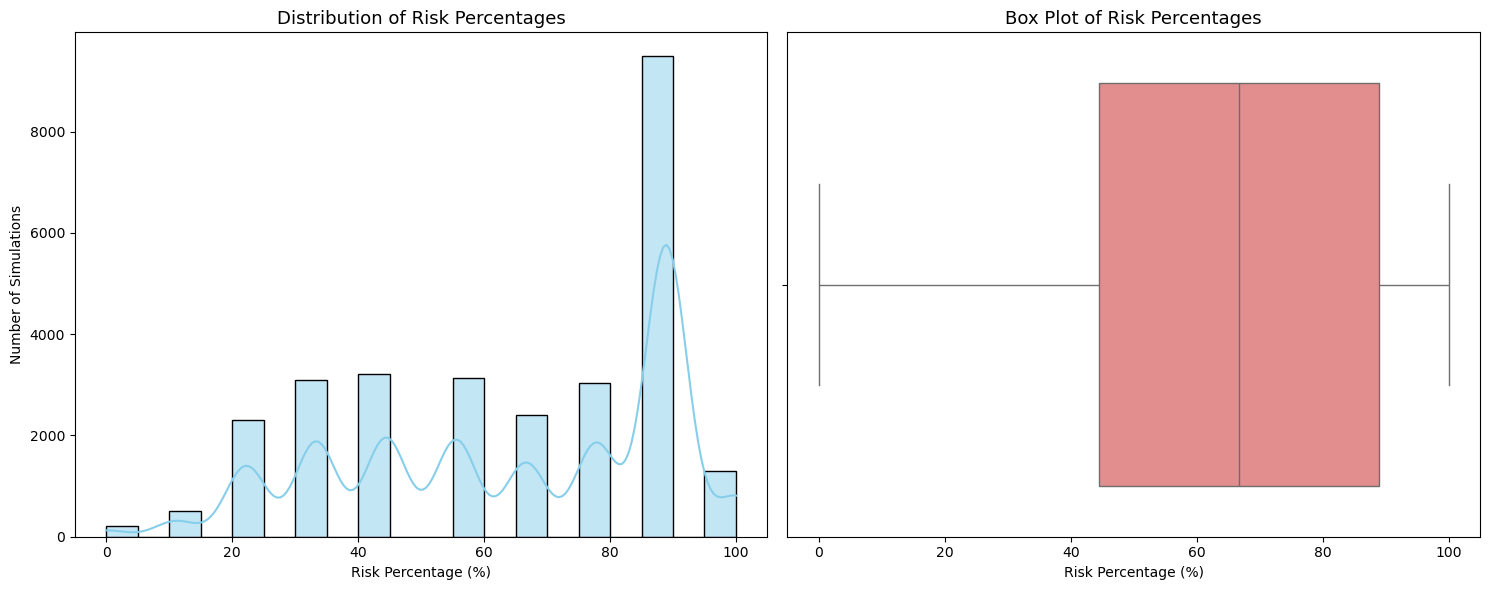

--- [Risk Statistics Details] ---
Risk 0.00% 구간: 204 개 시나리오 (0.71%)
Risk 11.11% 구간: 511 개 시나리오 (1.78%)
Risk 22.22% 구간: 2,297 개 시나리오 (8.01%)
Risk 33.33% 구간: 3,088 개 시나리오 (10.77%)
Risk 44.44% 구간: 3,209 개 시나리오 (11.19%)
Risk 55.56% 구간: 3,144 개 시나리오 (10.97%)
Risk 66.67% 구간: 2,396 개 시나리오 (8.36%)
Risk 77.78% 구간: 3,031 개 시나리오 (10.57%)
Risk 88.89% 구간: 9,486 개 시나리오 (33.08%)
Risk 100.00% 구간: 1,306 개 시나리오 (4.55%)


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# 그래프 스타일 설정
plt.style.use('seaborn-v0_8-muted')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 1. 히스토그램 (리스크 비율의 빈도 분포)
sns.histplot(risk_report_df['Risk_Percentage'], bins=20, kde=True, ax=ax1, color='skyblue')
ax1.set_title('Distribution of Risk Percentages', fontsize=13)
ax1.set_xlabel('Risk Percentage (%)')
ax1.set_ylabel('Number of Simulations')

# 2. 박스 플롯 (데이터의 사분위수 및 이상치 확인)
sns.boxplot(x=risk_report_df['Risk_Percentage'], ax=ax2, color='lightcoral')
ax2.set_title('Box Plot of Risk Percentages', fontsize=13)
ax2.set_xlabel('Risk Percentage (%)')

plt.tight_layout()
plt.show()

# 3. 주요 통계치 출력
print("--- [Risk Statistics Details] ---")
risk_counts = risk_report_df['Risk_Percentage'].value_counts().sort_index()
for risk, count in risk_counts.items():
    print(f"Risk {risk:.2f}% 구간: {count:,} 개 시나리오 ({(count/len(risk_report_df)*100):.2f}%)")